This script generates MBESv2 input from AACR_GENIE.
- Center: MSK
- Recurrency : #pts ≥ 2  

Kexin Dong  
Jan 15, 2023  

### Load dependencies

In [2]:
import os
import json
import requests
import gffutils
import Bio.Align
from Bio import pairwise2
from Bio.Data import CodonTable
import pegg
from itertools import product
import zipfile
import pandas as pd
import gc

In [ ]:
# load refgenome
path_h_ref, path_m_ref = '/Users/gorkordkx/Documents/Database/RefGenome/ncbi-2023-09-12/GCF_000001405.25_GRCh37.p13_genomic.fna.gz', '/Users/gorkordkx/Documents/Database/RefGenome/mouse-2023-09-13/GCF_000001635.27_GRCm39_genomic.fna.gz'
# remember to replace the paths with yours
records_h, index_list_h = h2m.genome_loader(path_h_ref)
records_m, index_list_m  = h2m.genome_loader(path_m_ref)
path_h_anno, path_m_anno = '/Users/gorkordkx/Documents/Database/Genecode/gencode_v19_GRCh37.db', '/Users/gorkordkx/Documents/Database/Genecode/gencode_vm33_GRCm39.db'
# remember to replace the paths with yours
db_h, db_m = h2m.anno_loader(path_h_anno), h2m.anno_loader(path_m_anno)

### Load AACR-GENIEv13.0
1. Keep MSK data

In [13]:
#df_mutation = pd.read_csv('/Users/gorkordkx/Desktop/Flab - Drylab/Database/AACR-GENIE/v13.1/data_mutations_extended.txt', header=0, sep='\t', comment="#", na_values = 'Not Applicable')


df_mutation = pd.read_csv('/Users/samgould/Desktop/AACR_v13.1/data_mutations_extended.txt', header=0, sep='\t', comment="#", na_values = 'Not Applicable')

# only keep MSK data
df_mutation = df_mutation.iloc[:,[0, 37,2, 5,6,9,10,11,13,16]].reset_index(drop=True)
df_mutation = df_mutation[df_mutation['Center']=='MSK'].reset_index(drop=True)
df_mutation = df_mutation[df_mutation['Variant_Type'] == 'SNP'].reset_index(drop=True)
df_mutation = df_mutation.dropna(subset='HGVSc').reset_index(drop=True)
df_mutation['HGVSc'] = [x.split(':')[0] for x in df_mutation['HGVSc']]
df_mutation = df_mutation.drop_duplicates().reset_index(drop=True)

/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_68512/2265309736.py:4: DtypeWarning: Columns (4,12,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mutation = pd.read_csv('/Users/samgould/Desktop/AACR_v13.1/data_mutations_extended.txt', header=0, sep='\t', comment="#", na_values = 'Not Applicable')


In [14]:
df_mutation

,Hugo_Symbol,HGVSc,Center,Start_Position,End_Position,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,Tumor_Sample_Barcode
0,SH2D1A,ENST00000371139.4,MSK,123504048,123504048,Missense_Mutation,SNP,G,T,GENIE-MSK-P-0048298-T02-IM6
1,KRAS,ENST00000256078.4,MSK,25378562,25378562,Missense_Mutation,SNP,C,T,GENIE-MSK-P-0030423-T01-IH3
2,TMPRSS2,ENST00000332149.5,MSK,42866465,42866465,Missense_Mutation,SNP,C,T,GENIE-MSK-P-0052339-T02-IM6
3,TAP2,ENST00000374897.2,MSK,32800190,32800190,Nonsense_Mutation,SNP,G,A,GENIE-MSK-P-0002113-T02-IM6
4,INPP4B,ENST00000262992.4,MSK,143003288,143003288,Missense_Mutation,SNP,T,G,GENIE-MSK-P-0043596-T01-IM6
...,...,...,...,...,...,...,...,...,...,...
442234,RNF43,ENST00000407977.2,MSK,56432308,56432308,Missense_Mutation,SNP,A,G,GENIE-MSK-P-0046563-T01-IM6
442235,CDK8,ENST00000381527.3,MSK,26959350,26959350,Missense_Mutation,SNP,G,C,GENIE-MSK-P-0029742-T01-IM6
442236,TP53,ENST00000269305.4,MSK,7578404,7578404,Missense_Mutation,SNP,A,T,GENIE-MSK-P-0041476-T01-IM6
442237,EP300,ENST00000263253.7,MSK,41553365,41553365,Nonsense_Mutation,SNP,G,T,GENIE-MSK-P-0066956-T02-IM7


2. Selected columns

In [15]:
df_mutation_count = df_mutation.groupby([df_mutation.columns.tolist()[x] for x in [0,1,3,4,5,6,7,8]], as_index = False).size()
df_mutation_count_sorted = df_mutation_count.sort_values(by = 'size')
df_mutation_count_sorted.columns =['gene_name_h', 'tx_id_h','start_h','end_h','class_h','type_h','ref_seq_h','alt_seq_h','count']
#df_mutation_count_sorted.reset_index(drop=True).to_csv('aacr_all_count.csv', index = False)

(array([186239.,  36631.,  11805.,   5093.,   2615.,   1564.,    948.,
           613.,    751.]),
 array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
         5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ]),
 <BarContainer object of 9 artists>)

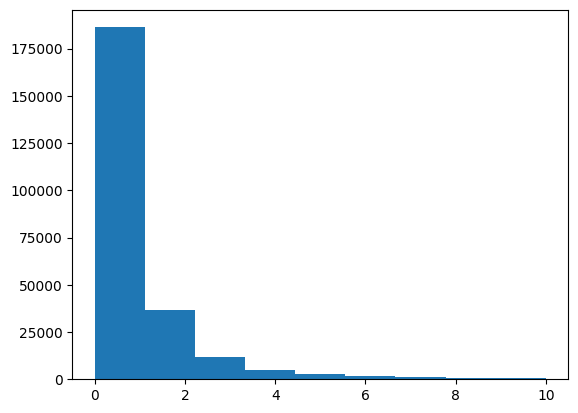

In [27]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(df_mutation_count['size'], bins= np.linspace(0,10,10))

3. Set # patient cut = 2

In [28]:
df_mutation_count_sorted_cut = df_mutation_count_sorted[df_mutation_count_sorted['count']>2].reset_index(drop=True)
len(df_mutation_count_sorted_cut)

25291

In [29]:
df_mutation_BE = df_mutation_count_sorted_cut.sort_values(by='gene_name_h').reset_index(drop=True)
df_mutation_BE['index'] = range(len(df_mutation_BE))
list_of_counts = df_mutation_BE['gene_name_h'].value_counts(sort=False).to_list()

In [18]:
df_mutation_BE = df_mutation_BE.iloc[:,[0,1,2,3,5,6,7,4,8,9]]

In [30]:
df_mutation_BE['class_h'].value_counts()

class_h
Missense_Mutation         20298
Nonsense_Mutation          3973
Splice_Site                 885
Intron                       49
Translation_Start_Site       42
5'UTR                        13
Nonstop_Mutation             11
3'UTR                         8
Splice_Region                 8
Silent                        4
Name: count, dtype: int64

In [20]:
list_of_coding = [
    'Missense_Mutation',
    'Nonsense_Mutation',
    'Nonstop_Mutation',
    'Silent'
]
df_mutation_BE_coding = df_mutation_BE[[x in list_of_coding for x in df_mutation_BE['class_h']]].reset_index(drop=True)
df_mutation_BE_non_coding = df_mutation_BE[[x not in list_of_coding for x in df_mutation_BE['class_h']]].reset_index(drop=True)

In [33]:
df_mutation_BE_coding

,gene_name_h,tx_id_h,start_h,end_h,type_h,ref_seq_h,alt_seq_h,class_h,count,index
0,ABL1,ENST00000318560.5,133738211,133738211,SNP,C,T,Missense_Mutation,5,2
1,ABL1,ENST00000318560.5,133759379,133759379,SNP,G,A,Missense_Mutation,6,3
2,ABL1,ENST00000318560.5,133750362,133750362,SNP,G,T,Missense_Mutation,3,4
3,ABL1,ENST00000318560.5,133760421,133760421,SNP,C,T,Missense_Mutation,3,5
4,ABL1,ENST00000318560.5,133759832,133759832,SNP,G,A,Missense_Mutation,3,6
...,...,...,...,...,...,...,...,...,...,...
24281,ZRSR2,ENST00000307771.7,15841322,15841322,SNP,C,T,Missense_Mutation,3,25286
24282,ZRSR2,ENST00000307771.7,15841301,15841301,SNP,G,A,Missense_Mutation,3,25287
24283,ZRSR2,ENST00000307771.7,15841030,15841030,SNP,G,A,Missense_Mutation,3,25288
24284,ZRSR2,ENST00000307771.7,15809091,15809091,SNP,A,T,Nonsense_Mutation,4,25289


In [ ]:
df_mutation_BE_non_coding.to_csv('input_MSK_over_2_non_coding.csv', index=False)
df_mutation_BE_coding.to_csv('input_MSK_over_2_coding.csv', index=False)
df_mutation_BE_non_coding.to_csv('input_MSK_over_2.csv', index=False)